In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from itertools import product
from multiprocessing import Pool

In [2]:
def is_in_numpy_array(elem, array):
    """Checks whether elem is identical to any row in array."""
    return np.any(np.equal(elem, array).all(axis=1))

side_length = 100
num_lines = 10 # called L in project description

# All possible directions
directions_1d = np.array([1,0,0, -1,0,0]).reshape(-1,3)

directions_3d = [[0,0,1], [0,1,0], [1,0,0], [0,0,-1], [0,-1,0], [-1, 0, 0]]
directions_3d = np.array([np.array(d) for d in directions_3d])

# Detachement direction consists of all 3d movements that are not 1d-movements
directions_3d_detach = [d for d in directions_3d if not is_in_numpy_array(d, directions_1d)]
directions_3d_detach = np.array(directions_3d_detach)

def choose(array):
    """Choose a random element from an array."""
    # np.random.choice doesn't work with 2d-array :(
    idx = np.random.randint(0, len(array))
    return array[idx]

def number_of_sliding_steps(avg_sliding_len=10):
    """Returns number of sliding steps drawn from a neg. bin. distr.
    See also:
    https://stackoverflow.com/questions/40846992/alternative-parametrization-of-the-negative-binomial-in-scipy
    """
    if avg_sliding_len == 0:
        return 0
    v = avg_sliding_len + avg_sliding_len**2
    p = 1 - (v - avg_sliding_len)/v
    return np.random.negative_binomial(1,p)

In [3]:
def simulate(args):
    avg_sliding_len, num_lines = args
    
    # Create lines parallel to x-axis
    lines_y = np.random.choice(side_length, size=num_lines, replace=False)
    lines_z = np.random.choice(side_length, size=num_lines, replace=False)

    # Create targets along line
    target_x = np.random.choice(side_length, size=num_lines, replace=False)
    targets = np.vstack((target_x, lines_y, lines_z)).T

    position = np.random.randint(0, side_length, 3)
    #print(f"Initial position = {position}")
    iterations_3d = 0
    iterations_1d = 0
    attach_counter = 0

    remaining_sliding_its = 0
    is_sliding = False
    
    while not is_in_numpy_array(position, targets):
        is_on_line = np.any((position[1] == lines_y) & (position[2] == lines_z))
        if is_on_line and not is_sliding:
            # Attach to line!
            remaining_sliding_its = number_of_sliding_steps(avg_sliding_len=avg_sliding_len)
            is_sliding = True
            attach_counter += 1
            #print(str(iterations_3d + iterations_1d) + f" Sliding for {remaining_sliding_its}")
        if remaining_sliding_its > 0:
            assert is_on_line
            # Currently sliding, 1d brownian motion
            iterations_1d += 1
            remaining_sliding_its -= 1
            direction = choose(directions_1d)
        else:
            # Not sliding, 3d brownian motion
            iterations_3d += 1
            if is_sliding:
                # Just detached.
                assert remaining_sliding_its <= 0
                direction = choose(directions_3d_detach)
                is_sliding = False
                #print("Detached!")
            else:            
                direction = choose(directions_3d)

        position += direction
        position = np.mod(position, np.array([side_length, side_length, side_length]))

    return avg_sliding_len, num_lines, iterations_3d, iterations_1d#, total_cost, attach_counter

In [4]:
%%time
sliding_len_grid = [10, 30, 50, 100, 200, 300]
num_lines_grid = [1, 10, 30, 100]

n_it = 1000
results = []

# Multithreading!
pool = Pool()

parameters = list(product(sliding_len_grid, num_lines_grid))*n_it
print(f"Running {len(parameters)} experiments")
results = pool.map(simulate, parameters)

print("Done.")

Running 24000 experiments
Done.
CPU times: user 3.71 s, sys: 779 ms, total: 4.49 s
Wall time: 1h 18min 51s


In [21]:

print("Saving CSV")
df = pd.DataFrame(results)
df.columns = ['avg_sliding', 'num_lines', 'it_1d', 'it_3d']
weighting_factor = 0.0
df['total_cost'] = weighting_factor * df['it_1d'] + df['it_3d']
#df.to_csv("results.csv")


Saving CSV


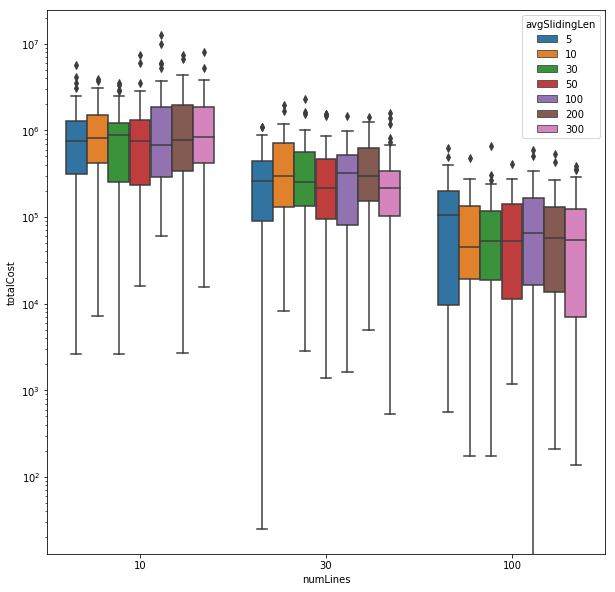

In [19]:
df = pd.read_csv('../results.csv')
weighting_factor = 0.1
df['totalCost'] = weighting_factor * df['iterations1D'] + df['iterations3D']
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.boxplot(x='numLines', y='totalCost', hue='avgSlidingLen', data=df, ax=ax)
ax.set_yscale('log')
fig.savefig('weight_0_1.jpg', bbox_inches='tight', transparent=True)

In [15]:
df.describe()

,avgSlidingLen,numLines,iterations1D,iterations3D
count,840.000000,840.000000,8.400000e+02,8.400000e+02
mean,99.285714,46.666667,1.315597e+05,5.725591e+05
std,103.240531,38.609111,3.692786e+05,1.053437e+06
min,5.000000,10.000000,0.000000e+00,0.000000e+00
25%,10.000000,10.000000,3.711750e+03,5.799700e+04
50%,50.000000,30.000000,1.975450e+04,2.174985e+05
75%,200.000000,100.000000,9.157800e+04,6.376488e+05
max,300.000000,100.000000,5.136451e+06,1.235070e+07


In [16]:
df.head(5)

,avgSlidingLen,numLines,iterations1D,iterations3D
0,5,10,572,138690
1,5,10,15501,1254473
2,5,10,2443,352626
3,5,10,15087,1198421
4,5,10,38741,4086916
